In [22]:
import os 
import yaml
import numpy as np 
import matplotlib.pyplot as plt 

datasets = ['dataset-room1_512_16', 'dataset-room1_512_16_8', 'dataset-room1_512_16_7', 'dataset-room1_512_16_6', 'dataset-room1_512_16_5', 'dataset-room1_512_16_4', 'dataset-room1_512_16_3', 'dataset-room1_512_16_2']
system = 'dm_vio'
imu = ['withimu', 'withoutimu']
path_to_results = '/home/cm2113/workspace/results'


In [23]:
def extract_results(data_folder):
    runs = sorted(os.listdir(data_folder))
    scale_error, trans_error = [], []
    for run in runs: 
        path = f'{data_folder}/{run}/saved_results/traj_est/absolute_err_statistics_sim3_-1.yaml'
        with open(path) as f:
            data = yaml.load(f, Loader=yaml.loader.FullLoader)
            scale_error.append(data["scale"]['rmse'])
            trans_error.append(data['trans']['rmse'])
    return scale_error, trans_error

In [24]:
res_s, res_t = {}, {}
std_s, std_t = {}, {}
runs = {}
for i in imu: 
    tot_s, tot_t = [], []
    s_s, s_t = [], []
    for dataset in datasets:
        data_folder = f'{path_to_results}/{dataset}/{system}/data/{i}'
        s, t = extract_results(data_folder)
        runs[dataset] = t
        tot_s.append(np.mean(s))
        tot_t.append(np.mean(t))
        s_s.append(np.std(s))
        s_t.append(np.std(t))
    res_s[i] = tot_s 
    res_t[i] = tot_t
    std_s[i] = s_s 
    std_t[i] = s_t

In [27]:
runs['dataset-room1_512_16_3']

[0.30593423411301957,
 0.3180169056357134,
 0.5331524232023314,
 0.831140182401044,
 0.8282031499909351,
 0.2913284176958233,
 0.29891702239714596,
 0.7303392682773108,
 0.3288421377842473,
 0.352338590843581]

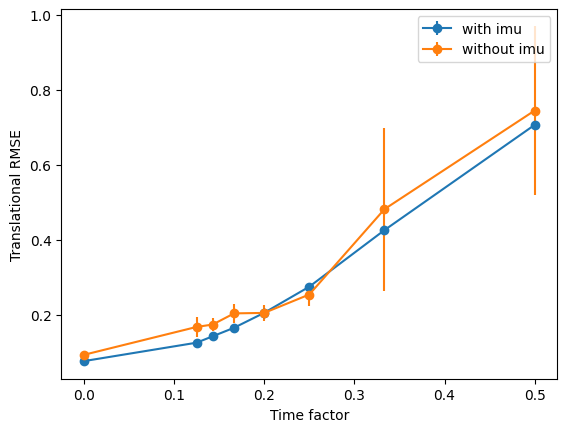

In [19]:
x = [0.0, 1.0/8.0, 1./7., 1./6., 1./5., 1./4., 1./3., 1./2.]
plt.figure()
plt.errorbar(x, res_t['withimu'], yerr=std_t['withimu'], fmt='-o', label='with imu')
plt.errorbar(x, res_t['withoutimu'], yerr=std_t['withoutimu'], fmt='-o', label='without imu')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()


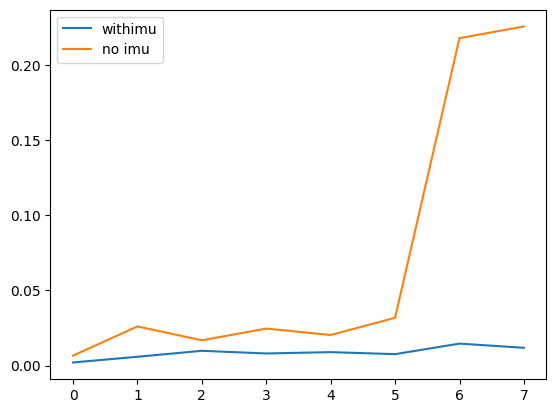

In [21]:
plt.figure()
plt.plot(std_t['withimu'], label='withimu')
plt.plot(std_t['withoutimu'], label='no imu')
plt.legend()
plt.show()